# AI at the Doctor's Office – End-to-End Demo

This single notebook:

1. Loads the **UCI Heart Disease** dataset.
2. Trains two models:
   - Logistic Regression (baseline)
   - Small Neural Network (MLPClassifier)
3. Evaluates both models.
4. Generates explainability artifacts with **LIME** and **SHAP**.
5. Provides an interactive panel to explore how changing patient features
   affects predicted risk.

You can run this top-to-bottom during your presentation.

In [1]:
# Install dependencies if needed (safe to re-run)
%pip install -q scikit-learn pandas numpy shap lime ipywidgets matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/275.7 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━ 266.2/275.7 kB 10.2 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay
)

import shap
from lime.lime_tabular import LimeTabularExplainer
from ipywidgets import interact, IntSlider

shap.initjs()

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1. Load and Inspect the Heart Disease Dataset

In [3]:
from sklearn.datasets import fetch_openml

heart = fetch_openml(name="heart-disease", version=1, as_frame=True)
df = heart.frame.copy()

print("Dataset:", heart.details['name'])
print(df.head())



Dataset: Heart-Disease
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  3.0     145.0  233.0  1.0      0.0    150.0    0.0      2.3   
1  37.0  1.0  2.0     130.0  250.0  0.0      1.0    187.0    0.0      3.5   
2  41.0  0.0  1.0     130.0  204.0  0.0      0.0    172.0    0.0      1.4   
3  56.0  1.0  1.0     120.0  236.0  0.0      1.0    178.0    0.0      0.8   
4  57.0  0.0  0.0     120.0  354.0  0.0      1.0    163.0    1.0      0.6   

   slope   ca  thal  target  
0    0.0  0.0   1.0     1.0  
1    0.0  0.0   2.0     1.0  
2    2.0  0.0   2.0     1.0  
3    2.0  0.0   2.0     1.0  
4    2.0  0.0   2.0     1.0  


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    float64
 12  thal      303 non-null    float64
 13  target    303 non-null    float64
dtypes: float64(14)
memory usage: 33.3 KB


In [5]:
df.describe(include='all')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


## 2. Preprocessing and Train/Validation/Test Split

In [6]:
from sklearn.model_selection import train_test_split

# Target column in this dataset
target_col = "target"
print("Target column:", target_col)

# Ensure it's integer (0 or 1)
df[target_col] = df[target_col].astype(int)

# y = the binary labels
y = df[target_col].values

# X = everything except target
X = df.drop(columns=[target_col])

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

# 4. Train/valid/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
)

X_train.shape, X_valid.shape, X_test.shape



Target column: target


((212, 13), (45, 13), (46, 13))

In [7]:
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

## 3. Model 1 – Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# LogReg model
logreg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

logreg_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", logreg),
    ]
)

# IMPORTANT: X_train, X_valid, y_train, y_valid are created in the previous cell.
logreg_clf.fit(X_train, y_train)

# ---- Validation metrics ----
y_valid_proba = logreg_clf.predict_proba(X_valid)[:, 1]  # same length as y_valid
y_valid_pred  = (y_valid_proba >= 0.5).astype(int)

print("Validation accuracy (LogReg):", accuracy_score(y_valid, y_valid_pred))
print("Validation ROC-AUC (LogReg):", roc_auc_score(y_valid, y_valid_proba))

# ---- Test metrics ----
y_test_proba = logreg_clf.predict_proba(X_test)[:, 1]
y_test_pred  = (y_test_proba >= 0.5).astype(int)

print("\nTest accuracy (LogReg):", accuracy_score(y_test, y_test_pred))
print("Test ROC-AUC (LogReg):", roc_auc_score(y_test, y_test_proba))
print("\nClassification report (test):\n", classification_report(y_test, y_test_pred))




Validation accuracy (LogReg): 0.7777777777777778
Validation ROC-AUC (LogReg): 0.878

Test accuracy (LogReg): 0.7391304347826086
Test ROC-AUC (LogReg): 0.8457142857142856

Classification report (test):
               precision    recall  f1-score   support

           0       0.76      0.62      0.68        21
           1       0.72      0.84      0.78        25

    accuracy                           0.74        46
   macro avg       0.74      0.73      0.73        46
weighted avg       0.74      0.74      0.74        46



In [9]:
y_test_proba = logreg_clf.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

print("Test accuracy (LogReg):", accuracy_score(y_test, y_test_pred))
print("Test ROC-AUC (LogReg):", roc_auc_score(y_test, y_test_proba))
print()
print(classification_report(y_test, y_test_pred))

Test accuracy (LogReg): 0.7391304347826086
Test ROC-AUC (LogReg): 0.8457142857142856

              precision    recall  f1-score   support

           0       0.76      0.62      0.68        21
           1       0.72      0.84      0.78        25

    accuracy                           0.74        46
   macro avg       0.74      0.73      0.73        46
weighted avg       0.74      0.74      0.74        46



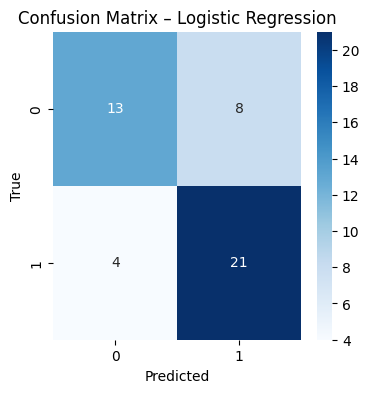

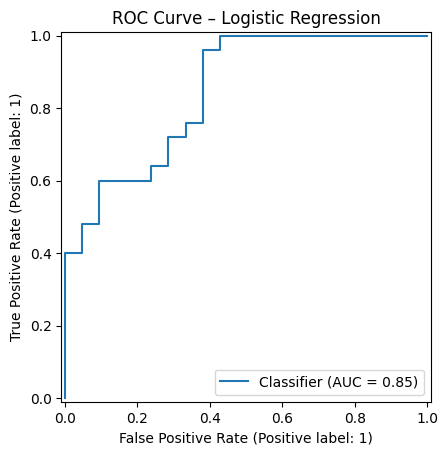

In [10]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve – Logistic Regression")
plt.show()

## 4. Model 2 – Small Neural Network (MLPClassifier)

In [11]:
mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation="relu",
    solver="adam",
    max_iter=500,
    random_state=RANDOM_STATE
)

mlp_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", mlp),
    ]
)

mlp_clf.fit(X_train, y_train)

y_valid_proba_mlp = mlp_clf.predict_proba(X_valid)[:, 1]
y_valid_pred_mlp = (y_valid_proba_mlp >= 0.5).astype(int)

print("Validation accuracy (MLP):", accuracy_score(y_valid, y_valid_pred_mlp))
print("Validation ROC-AUC (MLP):", roc_auc_score(y_valid, y_valid_proba_mlp))

Validation accuracy (MLP): 0.9111111111111111
Validation ROC-AUC (MLP): 0.9319999999999999


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [12]:
y_test_proba_mlp = mlp_clf.predict_proba(X_test)[:, 1]
y_test_pred_mlp = (y_test_proba_mlp >= 0.5).astype(int)

print("Test accuracy (MLP):", accuracy_score(y_test, y_test_pred_mlp))
print("Test ROC-AUC (MLP):", roc_auc_score(y_test, y_test_proba_mlp))
print()
print(classification_report(y_test, y_test_pred_mlp))

Test accuracy (MLP): 0.6956521739130435
Test ROC-AUC (MLP): 0.8304761904761905

              precision    recall  f1-score   support

           0       0.68      0.62      0.65        21
           1       0.70      0.76      0.73        25

    accuracy                           0.70        46
   macro avg       0.69      0.69      0.69        46
weighted avg       0.69      0.70      0.69        46



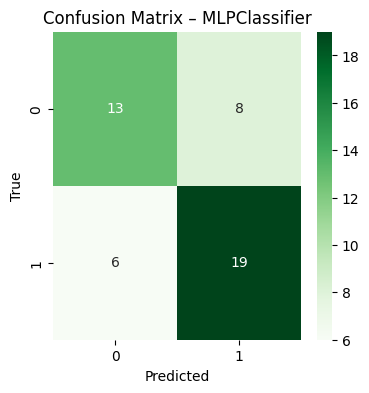

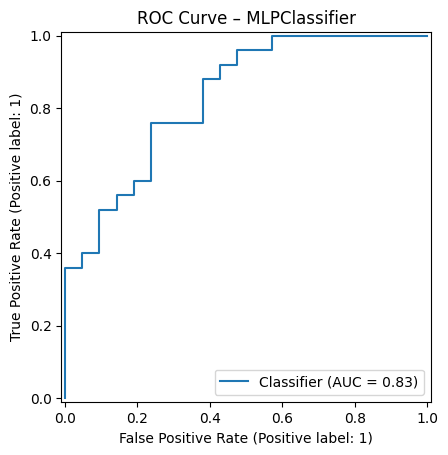

In [13]:
cm_mlp = confusion_matrix(y_test, y_test_pred_mlp)
plt.figure(figsize=(4,4))
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – MLPClassifier")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_test_proba_mlp)
plt.title("ROC Curve – MLPClassifier")
plt.show()

## 5. LIME – Local Explanations for a Single Patient

In [14]:
class_names = ["no_disease", "disease"]

lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=class_names,
    discretize_continuous=True,
    random_state=RANDOM_STATE,
)

idx = 0
instance = X_test.iloc[idx].values

def logreg_predict_proba(x):
    df_x = pd.DataFrame(x, columns=X_train.columns)
    return logreg_clf.predict_proba(df_x)

lime_exp = lime_explainer.explain_instance(
    data_row=instance,
    predict_fn=logreg_predict_proba,
    num_features=10,
)

lime_exp.show_in_notebook(show_table=True)

## 6. SHAP – Global and Local Explanations

  0%|          | 0/46 [00:00<?, ?it/s]

/tmp/ipython-input-3061594421.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_sample, show=True)


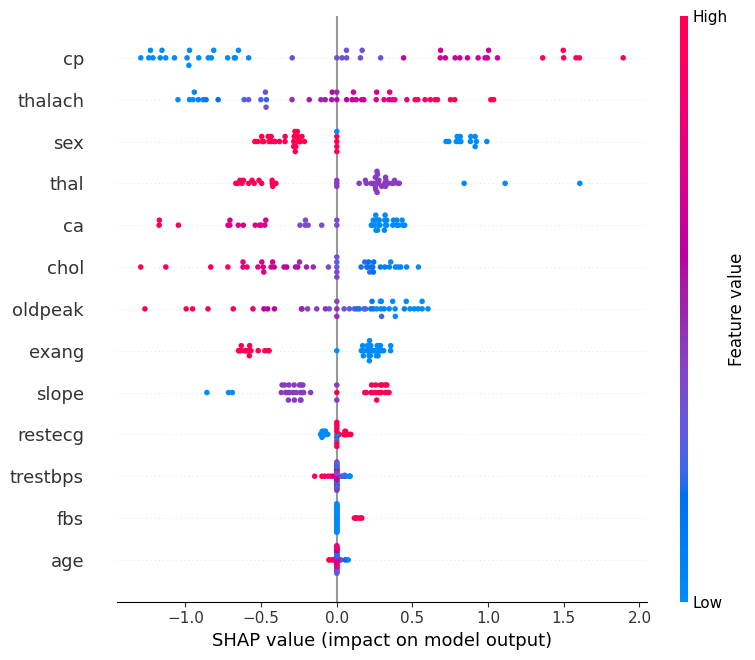

In [15]:
background = X_train.sample(n=min(100, len(X_train)), random_state=RANDOM_STATE)

def logreg_predict_proba_1d(x):
    df_x = pd.DataFrame(x, columns=X_train.columns)
    return logreg_clf.predict_proba(df_x)[:, 1]

explainer = shap.KernelExplainer(logreg_predict_proba_1d, background, link="logit")

X_test_sample = X_test.sample(n=min(100, len(X_test)), random_state=RANDOM_STATE)
shap_values = explainer.shap_values(X_test_sample, nsamples=200)

shap.summary_plot(shap_values, X_test_sample, show=True)

  0%|          | 0/1 [00:00<?, ?it/s]

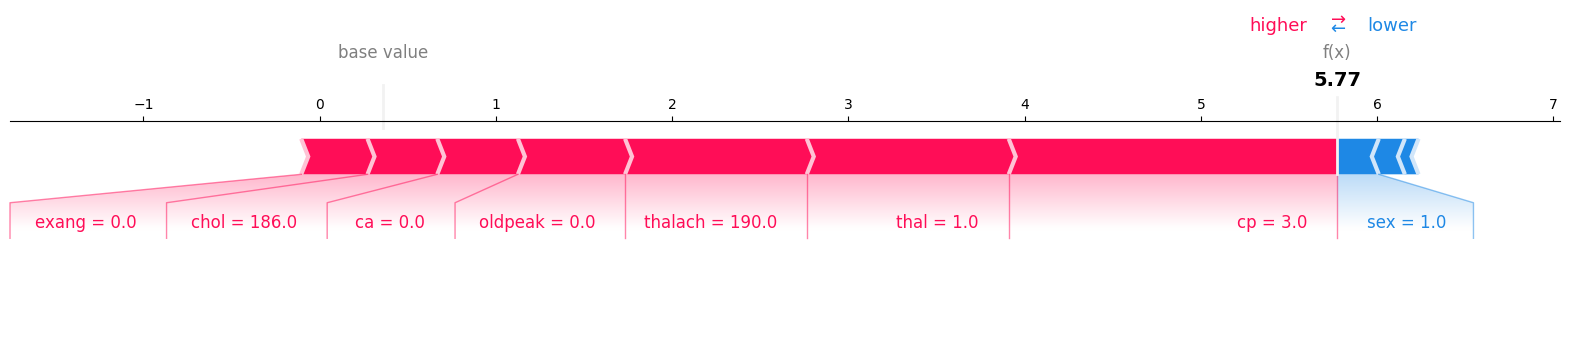

In [16]:
patient_idx = 0
x_patient = X_test_sample.iloc[patient_idx : patient_idx + 1]
shap_values_patient = explainer.shap_values(x_patient, nsamples=200)

shap.force_plot(explainer.expected_value, shap_values_patient, x_patient, matplotlib=True)

## 7. Interactive Patient Explorer (Clinician Teaching View)

In [17]:
base_patient = X_train.median(numeric_only=True)

for col in X.select_dtypes(exclude=["int64", "float64"]).columns:
    base_patient[col] = X_train[col].mode()[0]

age_range = (int(X_train["age"].min()), int(X_train["age"].max()))
trestbps_range = (int(X_train["trestbps"].min()), int(X_train["trestbps"].max()))
chol_range = (int(X_train["chol"].min()), int(X_train["chol"].max()))
thalach_range = (int(X_train["thalach"].min()), int(X_train["thalach"].max()))

In [19]:
def explore_patient(age, trestbps, chol, thalach):
    patient = base_patient.copy()
    patient["age"] = age
    patient["trestbps"] = trestbps
    patient["chol"] = chol
    patient["thalach"] = thalach

    for col in X_train.columns:
        if col not in patient.index:
            if col in numeric_features:
                patient[col] = X_train[col].median()
            else:
                patient[col] = X_train[col].mode()[0]

    df_patient = pd.DataFrame([patient[X_train.columns]])

    proba_logreg = logreg_clf.predict_proba(df_patient)[0, 1]
    proba_mlp = mlp_clf.predict_proba(df_patient)[0, 1]

    print(f"Predicted probability of heart disease:")
    print(f"  Logistic Regression: {proba_logreg:.3f}")
    print(f"  MLP (Neural Net):    {proba_mlp:.3f}")

    return df_patient

interact(
    explore_patient,
    age=IntSlider(value=int(base_patient["age"]), min=age_range[0], max=age_range[1], step=1, description="Age"),
    trestbps=IntSlider(value=int(base_patient["trestbps"]), min=trestbps_range[0], max=trestbps_range[1], step=1, description="Rest BP"),
    chol=IntSlider(value=int(base_patient["chol"]), min=chol_range[0], max=chol_range[1], step=1, description="Chol"),
    thalach=IntSlider(value=int(base_patient["thalach"]), min=thalach_range[0], max=thalach_range[1], step=1, description="Max HR"),
);

interactive(children=(IntSlider(value=55, description='Age', max=77, min=29), IntSlider(value=130, description…